In [61]:
# Install dependency (jika belum ada)
%pip install -q shap


Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
import json
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

print("Libraries loaded")
print(f"SHAP version: {shap.__version__}")


Libraries loaded
SHAP version: 0.50.0


## 1) Konfigurasi & Load Data

In [63]:
# Path & konfigurasi
INPUT_LABELED = "reddit_opinion_PSE_ISR_2024_window_labeled_textblob.csv"
ARTE_ML_DIR = Path("artefacts_2024_window_full")
XAI_OUTPUT_DIR = Path("xai_outputs")
XAI_OUTPUT_DIR.mkdir(exist_ok=True)

ALL_LABELS = ["Negatif", "Netral", "Positif"]
TEXT_PREF = ["final_text", "self_text"]
SEED = 42
np.random.seed(SEED)

print("Konfigurasi selesai")


Konfigurasi selesai


In [64]:
# Load data
assert os.path.exists(INPUT_LABELED), f"File tidak ditemukan: {INPUT_LABELED}"
df = pd.read_csv(INPUT_LABELED, low_memory=False)

TEXT_COL = next((c for c in TEXT_PREF if c in df.columns and df[c].notna().any()), None)
assert TEXT_COL is not None, "Tidak ada kolom teks valid"

if "month" not in df.columns:
    df["created_time"] = pd.to_datetime(df["created_time"])
    df["month"] = df["created_time"].dt.to_period("M").astype(str)

df = df[df["label"].isin(ALL_LABELS)].copy()
df["text"] = df[TEXT_COL].astype(str).str.strip()
df = df[df["text"] != ""].copy()

# Split temporal
train_months = [f"2024-{m:02d}" for m in range(1, 11)]
test_months = ["2024-11", "2024-12"]

df_tr = df[df["month"].isin(train_months)].copy()
df_te = df[df["month"].isin(test_months)].copy()

label2id = {lab: i for i, lab in enumerate(ALL_LABELS)}
df_tr["label_id"] = df_tr["label"].map(label2id)
df_te["label_id"] = df_te["label"].map(label2id)

X_test = df_te["text"].values
y_test = df_te["label_id"].values

print(f"Train rows: {len(df_tr):,} | Test rows: {len(df_te):,}")
print(f"Kolom teks: {TEXT_COL}")


Train rows: 493,903 | Test rows: 64,941
Kolom teks: final_text


## 2) Load Best Traditional ML Model (Stacking)

In [65]:
# Cari dan load model terbaik
meta_path = ARTE_ML_DIR / "model_meta.json"
if meta_path.exists():
    with open(meta_path, "r") as f:
        meta = json.load(f)
    best_pipeline_name = meta.get("best_pipeline", "stack_count")
else:
    best_pipeline_name = "stack_count"

model_path = ARTE_ML_DIR / f"best_{best_pipeline_name}.joblib"
if not model_path.exists():
    available_models = list(ARTE_ML_DIR.glob("best_*.joblib"))
    if available_models:
        model_path = available_models[0]
        best_pipeline_name = model_path.stem.replace("best_", "")

assert model_path.exists(), f"Model tidak ditemukan: {model_path}"

ml_pipeline = joblib.load(model_path)
print(f"Loaded ML model: {best_pipeline_name}")
print(f"Path: {model_path}")


Loaded ML model: stack_count
Path: artefacts_2024_window_full\best_stack_count.joblib


---

# PART A: SHAP untuk Traditional ML

In [66]:
# Sampling untuk SHAP
N_BACKGROUND = 100
N_EXPLAIN = 60

idx_bg = np.random.choice(len(X_test), size=min(N_BACKGROUND, len(X_test)), replace=False)
idx_explain = np.random.choice(len(X_test), size=min(N_EXPLAIN, len(X_test)), replace=False)

X_background = X_test[idx_bg]
X_explain = X_test[idx_explain]

print(f"Background samples: {len(X_background)}")
print(f"Samples to explain: {len(X_explain)}")


Background samples: 100
Samples to explain: 60


In [67]:
# Buat SHAP explainer
def ml_predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    return ml_pipeline.predict_proba(texts)

masker = shap.maskers.Text(tokenizer=r"\W+")

print("Membuat SHAP Explainer (bisa beberapa menit)...")
explainer_ml = shap.Explainer(
    ml_predict_proba,
    masker=masker,
    output_names=ALL_LABELS
)
print("SHAP Explainer siap")


Membuat SHAP Explainer (bisa beberapa menit)...
SHAP Explainer siap


In [68]:
# Hitung SHAP values untuk subset
print(f"Menghitung SHAP values untuk {len(X_explain)} sampel...")
shap_values_ml = explainer_ml(X_explain)
print("Selesai menghitung SHAP values")


Menghitung SHAP values untuk 60 sampel...
Selesai menghitung SHAP values


## 3) Pilih Contoh Wajib (Positif/Negatif/Netral/Misclass)

In [69]:
# Prediksi seluruh test
proba_test = ml_pipeline.predict_proba(X_test)
pred_labels = ml_pipeline.predict(X_test)

df_eval = df_te.copy()
df_eval["pred_label"] = pred_labels
df_eval["pred_conf"] = proba_test.max(axis=1)
df_eval["probabilities"] = [dict(zip(ALL_LABELS, row)) for row in proba_test]
df_eval["is_correct"] = df_eval["pred_label"] == df_eval["label"]

def pick_one(df_in, label, correct=True):
    sub = df_in[df_in["label"] == label]
    if correct is not None:
        sub = sub[sub["is_correct"] == correct]
    if sub.empty:
        return None
    return sub.sort_values("pred_conf", ascending=False).iloc[0]

picked = []
for lab in ALL_LABELS:
    row = pick_one(df_eval, lab, True)
    if row is not None:
        picked.append(row)

mis = df_eval[~df_eval["is_correct"]].sort_values("pred_conf", ascending=False).head(2)
selected = pd.concat([pd.DataFrame(picked), mis], ignore_index=True).drop_duplicates(subset="text").reset_index(drop=True)

display(
    selected[["text", "label", "pred_label", "pred_conf"]]
    .assign(text=lambda d: d["text"].str.slice(0, 180) + "...")
)


text    label pred_label  \
0  unrwa staff work gaza unrwa staff gaza unrwa p...  Negatif    Negatif   
1  dude sig clearli worst rifl ngsw object best r...   Netral     Netral   
2  context dart vs viper two air defens intercept...  Positif    Positif   
3  want true mani poll mani differ organis come r...  Positif     Netral   
4     jewish never mean never anyon free palestin...  Positif     Netral   

   pred_conf  
0   0.996913  
1   0.999745  
2   0.997401  
3   0.998892  
4   0.998543

In [70]:
# SHAP values untuk contoh terpilih
X_selected = selected["text"].tolist()
shap_selected = explainer_ml(X_selected)
print(f"SHAP dihitung untuk {len(X_selected)} contoh terpilih")


SHAP dihitung untuk 5 contoh terpilih


In [71]:
# Utilitas tabel token
def token_table(shap_sample, class_idx, top_k=8):
    tokens = shap_sample.data
    values = shap_sample.values[:, class_idx]
    df_tok = pd.DataFrame({"Token": tokens, "SHAP": values})
    df_tok["Contribution"] = np.where(df_tok["SHAP"] >= 0, "positif", "negatif")
    return df_tok.reindex(df_tok["SHAP"].abs().sort_values(ascending=False).index).head(top_k)


## 4) Tabel Ringkas per Contoh

In [72]:
summary_rows = []
for i, row in selected.iterrows():
    probs = ml_pipeline.predict_proba([row["text"]])[0]
    pred_idx = np.argmax(probs)
    tok = token_table(shap_selected[i], pred_idx, top_k=6)
    summary_rows.append({
        "Example ID": i + 1,
        "True Label": row["label"],
        "Predicted Label": row["pred_label"],
        "Confidence": round(probs[pred_idx], 3),
        "Dominant Tokens (SHAP)": ", ".join(
            f"{t} ({'+' if v > 0 else '-'}{abs(v):.3f})" for t, v in zip(tok["Token"], tok["SHAP"])
        )
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)


Example ID True Label Predicted Label  Confidence  \
0           1    Negatif         Negatif       0.997   
1           2     Netral          Netral       1.000   
2           3    Positif         Positif       0.997   
3           4    Positif          Netral       0.999   
4           5    Positif          Netral       0.999   

                              Dominant Tokens (SHAP)  
0  least  (+0.097), primari  (+0.097), mean  (+0....  
1  worst  (+0.010), sig  (-0.005), object  (+0.00...  
2  full  (+0.121), full  (+0.087), smile  (+0.068...  
3  simplest  (+0.095), true  (-0.074), fake  (-0....  
4  mean  (-0.226), jewish  (+0.180), never  (+0.0...

## 5) Detail Token per Contoh

In [73]:
for i, row in selected.iterrows():
    probs = ml_pipeline.predict_proba([row["text"]])[0]
    target_idx = np.argmax(probs)
    tok_df = token_table(shap_selected[i], target_idx, top_k=10)
    print(f"\nExample {i+1} | True: {row['label']} | Pred: {row['pred_label']} | Conf: {probs[target_idx]:.3f}")
    print(f"Text: {row['text'][:200]}...\n")
    display(tok_df[["Token", "SHAP", "Contribution"]])



Example 1 | True: Negatif | Pred: Negatif | Conf: 0.997
Text: unrwa staff work gaza unrwa staff gaza unrwa posit direct israel intellig servic work unrwa vet unrwa employe much unrwa pay israel intellig servic vet unrwa employe unrwa need thorough background che...



Token      SHAP Contribution
66      least   0.096663      positif
67    primari   0.096663      positif
113      mean   0.083515      positif
112    doesnt   0.083515      positif
68   function   0.082717      positif
69       mean   0.082717      positif
190      base   0.072772      positif
191    geneva   0.072772      positif
196      also   0.059517      positif
197      base   0.059517      positif


Example 2 | True: Netral | Pred: Netral | Conf: 1.000
Text: dude sig clearli worst rifl ngsw object best rifl ever made...



Token      SHAP Contribution
3     worst   0.009557      positif
1       sig  -0.004604      negatif
6    object   0.004235      positif
10      made  0.003591      positif
2   clearli   0.002426      positif
8      rifl   0.002344      positif
4      rifl   0.001483      positif
9      ever   0.001438      positif
7      best  -0.001276      negatif
0      dude   0.000132      positif


Example 3 | True: Positif | Pred: Positif | Conf: 0.997
Text: context dart vs viper two air defens interceptor pilot vs two tactic fighter pilot michael townsend ltc usaf ret viper pierr bucko geni fmo rafsob circa captain station tyndal afb f instructor day win...



Token      SHAP Contribution
117        full   0.120678      positif
140        full   0.087310      positif
153       smile   0.068263      positif
46          afb   0.056868      positif
270        safe   0.052485      positif
271        area   0.052485      positif
109        much   0.051164      positif
47   instructor   0.048484      positif
105         far   0.047687      positif
141      weapon   0.042357      positif


Example 4 | True: Positif | Pred: Netral | Conf: 0.999
Text: want true mani poll mani differ organis come roughli except heard simplest explan true hama manag fake everi singl poll...



Token      SHAP Contribution
11  simplest   0.094778      positif
13      true  -0.073900      negatif
16      fake  -0.037423      negatif
1       true  -0.023522      negatif
8    roughli   0.018504      positif
3       poll   0.008020      positif
9     except   0.006105      positif
19       poll  0.005584      positif
2       mani   0.005393      positif
15     manag   0.004475      positif


Example 5 | True: Positif | Pred: Netral | Conf: 0.999
Text: jewish never mean never anyon free palestin...



Token      SHAP Contribution
2     mean  -0.225537      negatif
0   jewish   0.180433      positif
1    never   0.078035      positif
5     free  -0.017713      negatif
3    never   0.002724      positif
6  palestin  0.000916      positif
4    anyon  -0.000735      negatif

### 📊 Visualisasi SHAP Text Plot (Interaktif)

In [74]:
# Tampilkan SHAP text plot untuk 3 contoh pertama (sangat visual)
print("="*60)
print("SHAP TEXT VISUALIZATION - Kontribusi Kata Interaktif")
print("="*60)

for i in range(min(3, len(shap_selected))):
    row = selected.iloc[i]
    print(f"\n{'='*60}")
    print(f"Example {i+1}: {row['label']} → {row['pred_label']}")
    print(f"Text: {row['text'][:150]}...")
    print("="*60)
    
    # SHAP text plot (warna merah/biru menunjukkan kontribusi)
    shap.plots.text(shap_selected[i])
    print("\n")

SHAP TEXT VISUALIZATION - Kontribusi Kata Interaktif

Example 1: Negatif → Negatif
Text: unrwa staff work gaza unrwa staff gaza unrwa posit direct israel intellig servic work unrwa vet unrwa employe much unrwa pay israel intellig servic ve...





Example 2: Netral → Netral
Text: dude sig clearli worst rifl ngsw object best rifl ever made...





Example 3: Positif → Positif
Text: context dart vs viper two air defens interceptor pilot vs two tactic fighter pilot michael townsend ltc usaf ret viper pierr bucko geni fmo rafsob cir...


## 6) Error Analysis (Misclassification)

In [75]:
mis_tab = selected[~selected["is_correct"]][["text", "label", "pred_label", "pred_conf"]].copy()
if mis_tab.empty:
    print("Tidak ada misclassification di subset terpilih.")
else:
    mis_tab["text"] = mis_tab["text"].str.slice(0, 180) + "..."
    display(mis_tab.rename(columns={"label": "True label", "pred_label": "Predicted", "pred_conf": "Confidence"}))


text True label Predicted  \
3  want true mani poll mani differ organis come r...    Positif    Netral   
4     jewish never mean never anyon free palestin...    Positif    Netral   

   Confidence  
3    0.998892  
4    0.998543

### 🔍 Error Analysis Mendalam (dengan Insight)

In [76]:
# Analisis mendalam untuk misclassified examples
misclassified = selected[~selected["is_correct"]].copy()

if not misclassified.empty:
    error_analysis = []
    
    for idx, row in misclassified.iterrows():
        # Get SHAP values
        shap_idx = selected.index.get_loc(idx)
        probs = ml_pipeline.predict_proba([row["text"]])[0]
        pred_idx = np.argmax(probs)
        
        # Top tokens yang mempengaruhi prediksi salah
        tok = token_table(shap_selected[shap_idx], pred_idx, top_k=5)
        dominant_tokens = ", ".join([f"{t}({v:+.2f})" for t, v in zip(tok["Token"], tok["SHAP"])])
        
        # Analisis sederhana
        text_lower = row["text"].lower()
        insights = []
        
        # Cek sarkasme/negasi
        if any(word in text_lower for word in ["not", "never", "no", "isn't", "don't", "didn't"]):
            insights.append("Kemungkinan negasi/sarkasme")
        
        # Cek mixed sentiment
        if row["label"] != row["pred_label"]:
            true_idx = label2id[row["label"]]
            if probs[true_idx] > 0.2:  # Confidence cukup tinggi di kelas lain
                insights.append("Mixed sentiment")
        
        # Cek konteks kompleks
        if len(row["text"].split()) > 100:
            insights.append("Teks panjang/kompleks")
        
        if not insights:
            insights.append("Perlu analisis manual")
        
        error_analysis.append({
            "Text": row["text"][:100] + "...",
            "True Label": row["label"],
            "Predicted": row["pred_label"],
            "Confidence": round(probs[pred_idx], 3),
            "Dominant Tokens": dominant_tokens,
            "Analisis Singkat": "; ".join(insights)
        })
    
    error_df = pd.DataFrame(error_analysis)
    print("\n" + "="*80)
    print("TABEL ERROR ANALYSIS - Misclassification dengan Insight")
    print("="*80)
    display(error_df)
    
    # Export ke CSV
    error_csv_path = XAI_OUTPUT_DIR / "error_analysis_detailed.csv"
    error_df.to_csv(error_csv_path, index=False)
    print(f"\n✅ Error analysis exported to: {error_csv_path}")
else:
    print("✅ Tidak ada misclassification di subset terpilih.")


TABEL ERROR ANALYSIS - Misclassification dengan Insight


Text True Label Predicted  \
0  want true mani poll mani differ organis come r...    Positif    Netral   
1     jewish never mean never anyon free palestin...    Positif    Netral   

   Confidence                                    Dominant Tokens  \
0       0.999  simplest (+0.09), true (-0.07), fake (-0.04), ...   
1       0.999  mean (-0.23), jewish (+0.18), never (+0.08), f...   

              Analisis Singkat  
0        Perlu analisis manual  
1  Kemungkinan negasi/sarkasme


✅ Error analysis exported to: xai_outputs\error_analysis_detailed.csv


## 7) SHAP Global Feature Importance

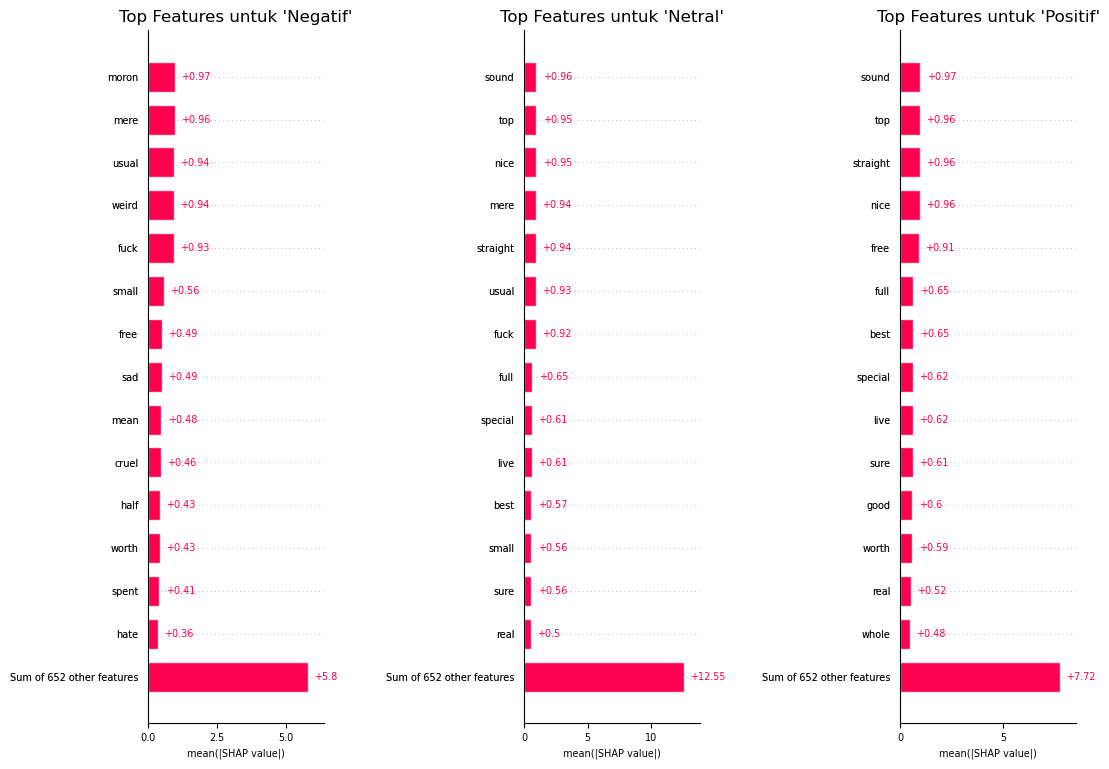

Plot disimpan ke: xai_outputs\shap_ml_feature_importance_spaced.png


In [77]:
import matplotlib.pyplot as plt
import shap

CORRECTED_LABELS = ['Negatif', 'Netral', 'Positif']

# Bersihkan figure lama
plt.close('all')

# Ukuran normal, bar tetap proporsional
fig, axes = plt.subplots(1, 3, figsize=(26, 8))

# Gambar SHAP bar untuk tiap kelas
for idx, label in enumerate(CORRECTED_LABELS):
    ax = axes[idx]
    plt.sca(ax)
    shap.plots.bar(shap_values_ml[:, :, idx], max_display=15, show=False)
    ax.set_title(f"Top Features untuk '{label}'", fontsize=12)  # judul diperkecil

# PERKECIL FONT SEMUA ELEMEN
for ax in axes:
    # label sumbu Y (kata-kata)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(7)
    # label sumbu X
    for tick in ax.get_xticklabels():
        tick.set_fontsize(7)
    # teks angka di ujung bar / teks lain
    for txt in ax.texts:
        txt.set_fontsize(7)
    # label axis
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)

# === GESER POSISI SUBPLOT SUPAYA JAUH ===
# x0 = posisi kiri tiap subplot (0–1), width = lebar subplot
x0_list = [0.01, 0.48, 0.95]  # NEG, NET, POS (jarak cukup jauh)
width   = 0.22                # lebar masing-masing axes

for ax, x0 in zip(axes, x0_list):
    pos = ax.get_position()
    ax.set_position([x0, pos.y0, width, pos.height])
# =======================================

output_path = XAI_OUTPUT_DIR / "shap_ml_feature_importance_spaced.png"
fig.savefig(output_path, dpi=150)  # TANPA bbox_inches="tight"
plt.show()
print("Plot disimpan ke:", output_path)


### 📈 Agregasi Top Tokens per Kelas (dari Multiple Samples)

In [78]:
# Agregasi top tokens dari semua samples yang di-explain
print("Mengagregasi top tokens dari SHAP values...")

aggregated_tokens = {label: {} for label in ALL_LABELS}

# Iterasi semua SHAP values
for i in range(len(shap_values_ml)):
    tokens = shap_values_ml[i].data
    
    for class_idx, label in enumerate(ALL_LABELS):
        values = shap_values_ml[i].values[:, class_idx]
        
        for token, value in zip(tokens, values):
            if token.strip():  # Skip empty tokens
                if token not in aggregated_tokens[label]:
                    aggregated_tokens[label][token] = []
                aggregated_tokens[label][token].append(value)

# Hitung rata-rata dan buat DataFrame
aggregated_results = []

for label in ALL_LABELS:
    token_means = {}
    for token, values in aggregated_tokens[label].items():
        token_means[token] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'count': len(values)
        }
    
    # Sort by absolute mean
    sorted_tokens = sorted(token_means.items(), 
                          key=lambda x: abs(x[1]['mean']), 
                          reverse=True)[:15]
    
    for rank, (token, stats) in enumerate(sorted_tokens, 1):
        aggregated_results.append({
            'Sentiment Class': label,
            'Rank': rank,
            'Token': token,
            'Mean SHAP': round(stats['mean'], 4),
            'Std Dev': round(stats['std'], 4),
            'Frequency': stats['count'],
            'Direction': 'Positive' if stats['mean'] > 0 else 'Negative'
        })

agg_df = pd.DataFrame(aggregated_results)

# Display per class
print("\n" + "="*80)
print("TOP TOKENS PER SENTIMENT CLASS (Aggregated)")
print("="*80)

for label in ALL_LABELS:
    print(f"\n{label.upper()}:")
    print("-" * 60)
    class_df = agg_df[agg_df['Sentiment Class'] == label].head(12)
    display(class_df[['Rank', 'Token', 'Mean SHAP', 'Direction', 'Frequency']])

# Export
agg_csv_path = XAI_OUTPUT_DIR / "aggregated_top_tokens.csv"
agg_df.to_csv(agg_csv_path, index=False)
print(f"\n✅ Aggregated tokens exported to: {agg_csv_path}")

Mengagregasi top tokens dari SHAP values...

TOP TOKENS PER SENTIMENT CLASS (Aggregated)

NEGATIF:
------------------------------------------------------------


Rank   Token  Mean SHAP Direction  Frequency
0      1  moron      0.9662  Positive          1
1      2   mere      0.9605  Positive          1
2      3  usual      0.9422  Positive          1
3      4  weird      0.9363  Positive          1
4      5   fuck      0.9309  Positive          1
5      6  small      0.5614  Positive          2
6      7    good    -0.4937  Negative          1
7      8   free     -0.4906  Negative          1
8      9    sad      0.4880  Positive          1
9     10   mean      0.4766  Positive          2
10    11  cruel      0.4633  Positive          1
11    12    less     0.4451  Positive          1


NETRAL:
------------------------------------------------------------


Rank      Token  Mean SHAP Direction  Frequency
15     1     sound     -0.9593  Negative          1
16     2       top     -0.9513  Negative          1
17     3      nice     -0.9495  Negative          1
18     4      mere     -0.9443  Negative          1
19     5  straight     -0.9410  Negative          1
20     6     usual     -0.9307  Negative          1
21     7      fuck     -0.9165  Negative          1
22     8      right    -0.7117  Negative          2
23     9      full     -0.6458  Negative          1
24    10   special     -0.6109  Negative          1
25    11      live     -0.6087  Negative          2
26    12      best     -0.5678  Negative          2


POSITIF:
------------------------------------------------------------


Rank      Token  Mean SHAP Direction  Frequency
30     1       good     0.9729  Positive          1
31     2     sound      0.9697  Positive          1
32     3       top      0.9647  Positive          1
33     4  straight      0.9610  Positive          1
34     5      nice      0.9608  Positive          1
35     6      free      0.9124  Positive          1
36     7      right     0.7166  Positive          2
37     8      full      0.6472  Positive          1
38     9      best      0.6453  Positive          2
39    10   special      0.6184  Positive          1
40    11      live      0.6164  Positive          2
41    12      sure      0.6117  Positive          5


✅ Aggregated tokens exported to: xai_outputs\aggregated_top_tokens.csv


### 📊 Visualisasi Agregasi Top Tokens

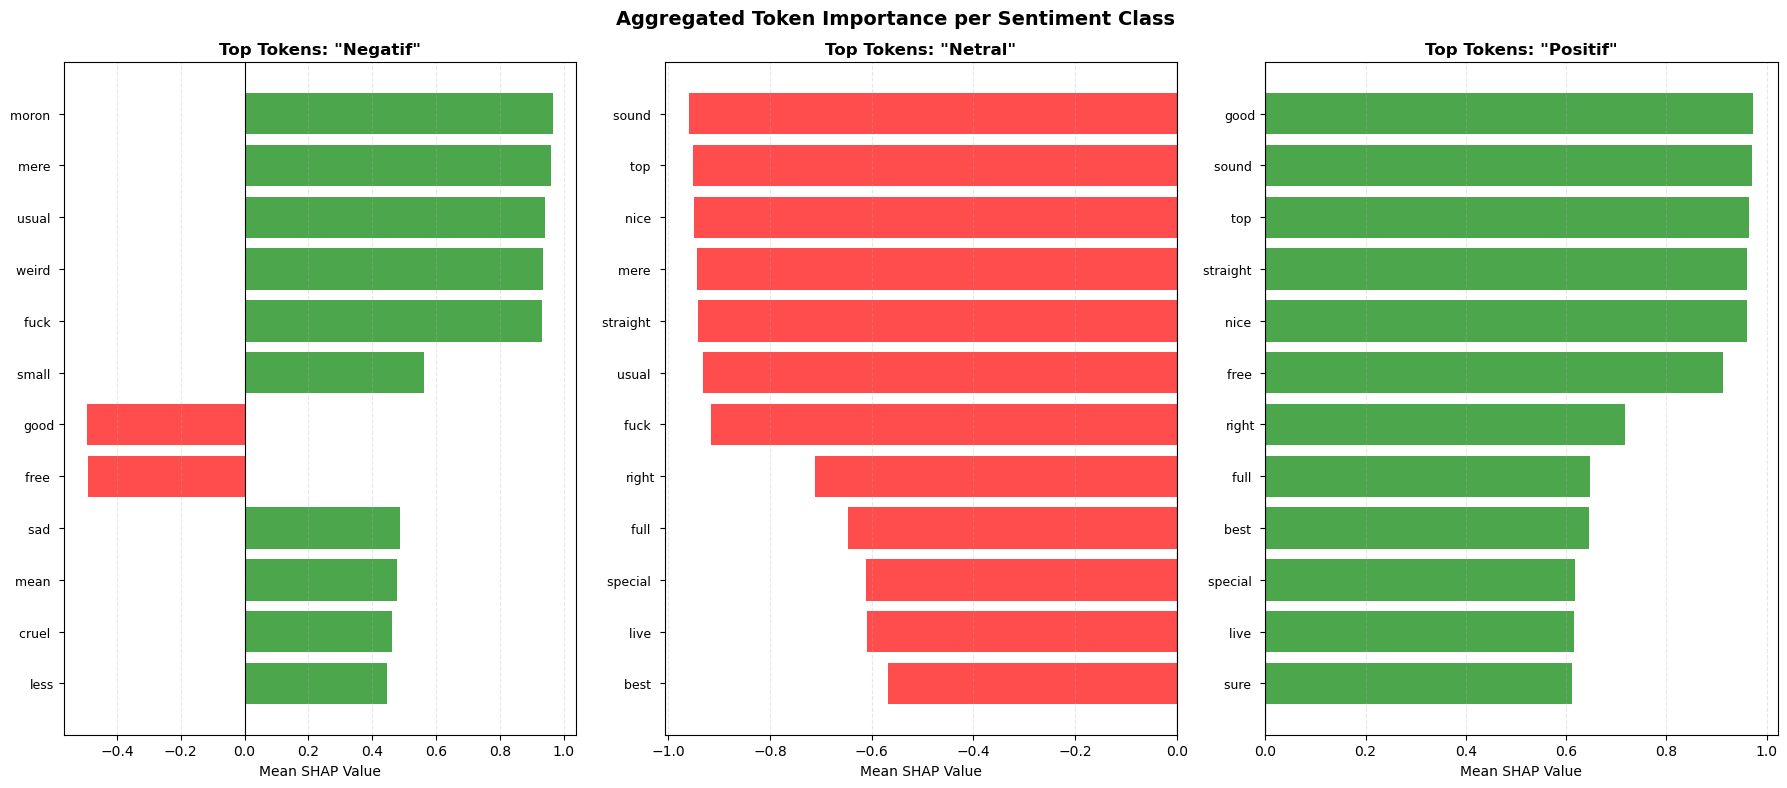

✅ Plot saved to: xai_outputs\aggregated_tokens_bar_plot.png


In [79]:
# Plot horizontal bar chart untuk top tokens per class
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for idx, label in enumerate(ALL_LABELS):
    ax = axes[idx]
    
    class_data = agg_df[agg_df['Sentiment Class'] == label].head(12)
    tokens = class_data['Token'].values
    means = class_data['Mean SHAP'].values
    colors = ['green' if m > 0 else 'red' for m in means]
    
    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, means, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_xlabel('Mean SHAP Value', fontsize=10)
    ax.set_title(f'Top Tokens: "{label}"', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.invert_yaxis()
    
    # Add grid
    ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.suptitle('Aggregated Token Importance per Sentiment Class', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()

agg_plot_path = XAI_OUTPUT_DIR / "aggregated_tokens_bar_plot.png"
plt.savefig(agg_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to: {agg_plot_path}")

## 8) Ringkasan Output

In [80]:
print(f"Folder output: {XAI_OUTPUT_DIR.resolve()}")
print("File yang dihasilkan:")
for f in sorted(XAI_OUTPUT_DIR.glob("*")):
    size = f.stat().st_size / 1024
    print(f"  - {f.name} ({size:.1f} KB)")

print("\nInterpretasi singkat:")
print("1. SHAP positif: mendukung kelas prediksi; negatif: menentang.")
print("2. Tabel ringkas menunjukkan token dominan per contoh.")
print("3. Tabel error membantu memahami pola salah prediksi.")
print("4. Plot global menyorot token penting secara agregat.")


Folder output: D:\UMN\Machine Learning\Israel-Palestine-Sentiment-Analysis\xai_outputs
File yang dihasilkan:
  - aggregated_tokens_bar_plot.png (109.2 KB)
  - aggregated_top_tokens.csv (1.9 KB)
  - error_analysis_detailed.csv (0.5 KB)
  - shap_ml_feature_importance.png (132.4 KB)
  - shap_ml_feature_importance_spaced.png (69.5 KB)

Interpretasi singkat:
1. SHAP positif: mendukung kelas prediksi; negatif: menentang.
2. Tabel ringkas menunjukkan token dominan per contoh.
3. Tabel error membantu memahami pola salah prediksi.
4. Plot global menyorot token penting secara agregat.


---

# PART B: SHAP untuk Deep Learning (BERT) - OPTIONAL

In [81]:
# Load BERT model jika tersedia
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BERT_MODEL_DIR = Path("artefacts_2024_window_deep") / "bert_model"
BERT_TOKENIZER_DIR = Path("artefacts_2024_window_deep") / "bert_tokenizer"

BERT_AVAILABLE = BERT_MODEL_DIR.exists() and BERT_TOKENIZER_DIR.exists()

if BERT_AVAILABLE:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    print("Loading BERT model...")
    bert_tokenizer = AutoTokenizer.from_pretrained(BERT_TOKENIZER_DIR)
    bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_DIR).to(device)
    bert_model.eval()
    print("✅ BERT model loaded")
    
    MAX_LEN_BERT = 128
    
    def bert_predict_proba(texts):
        """Predict probabilities using BERT"""
        if isinstance(texts, str):
            texts = [texts]
        
        bert_model.eval()
        all_probs = []
        
        with torch.no_grad():
            for i in range(0, len(texts), 16):
                batch_texts = texts[i:i+16]
                encoded = bert_tokenizer(
                    list(batch_texts),
                    padding="max_length",
                    truncation=True,
                    max_length=MAX_LEN_BERT,
                    return_tensors="pt"
                )
                
                input_ids = encoded["input_ids"].to(device)
                attention_mask = encoded["attention_mask"].to(device)
                
                outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
                all_probs.append(probs)
        
        return np.vstack(all_probs)
    
    print("✅ BERT predict function ready")
else:
    print("⚠️ BERT model tidak ditemukan. Skip SHAP untuk BERT.")
    print("   Jalankan notebook 05 terlebih dahulu untuk melatih BERT.")

ModuleNotFoundError: No module named 'torch'

### SHAP untuk BERT (lebih lambat)

In [ ]:
if BERT_AVAILABLE:
    print("Membuat SHAP Explainer untuk BERT...")
    print("⚠️ BERT SHAP sangat lambat, hanya gunakan 3 sampel untuk demo")
    
    # Gunakan subset kecil untuk BERT
    X_bert_explain = X_selected[:3]  # Hanya 3 contoh
    
    masker_bert = shap.maskers.Text(tokenizer=r"\W+")
    explainer_bert = shap.Explainer(
        bert_predict_proba,
        masker=masker_bert,
        output_names=ALL_LABELS
    )
    
    print("Menghitung SHAP values untuk BERT (ini akan memakan waktu lama)...")
    shap_values_bert = explainer_bert(X_bert_explain)
    print("✅ SHAP values BERT selesai")
    
    # Text plot untuk BERT
    print("\n" + "="*60)
    print("SHAP TEXT PLOT - BERT")
    print("="*60)
    for i in range(len(shap_values_bert)):
        print(f"\nBERT Example {i+1}:")
        shap.plots.text(shap_values_bert[i])
else:
    print("BERT tidak tersedia, skip.")

---

## 🔄 Perbandingan XAI: Traditional ML vs BERT

In [ ]:
if BERT_AVAILABLE:
    print("="*80)
    print("PERBANDINGAN: Traditional ML vs BERT")
    print("="*80)
    
    comparison_data = []
    
    # Untuk setiap kelas, bandingkan top tokens
    for class_idx, label in enumerate(ALL_LABELS):
        # ML top tokens
        ml_class = agg_df[agg_df['Sentiment Class'] == label].head(10)
        ml_tokens = ml_class['Token'].tolist()
        ml_top = ", ".join(ml_tokens[:5])
        
        # BERT top tokens (dari shap_values_bert)
        if len(shap_values_bert) > 0:
            bert_tokens_all = []
            for i in range(len(shap_values_bert)):
                tokens = shap_values_bert[i].data
                values = shap_values_bert[i].values[:, class_idx]
                
                # Get top tokens by absolute value
                top_indices = np.argsort(np.abs(values))[-10:]
                for idx in top_indices:
                    if tokens[idx].strip():
                        bert_tokens_all.append((tokens[idx], values[idx]))
            
            # Sort by average
            from collections import defaultdict
            bert_agg = defaultdict(list)
            for token, value in bert_tokens_all:
                bert_agg[token].append(value)
            
            bert_sorted = sorted(bert_agg.items(), 
                               key=lambda x: abs(np.mean(x[1])), 
                               reverse=True)[:5]
            bert_top = ", ".join([t[0] for t in bert_sorted])
        else:
            bert_top = "N/A"
        
        comparison_data.append({
            'Sentiment Class': label,
            'Traditional ML Top Tokens': ml_top,
            'BERT Top Tokens': bert_top,
            'Catatan': 'ML fokus kata individual; BERT kontekstual'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Export
    comp_path = XAI_OUTPUT_DIR / "model_comparison_ml_vs_bert.csv"
    comparison_df.to_csv(comp_path, index=False)
    print(f"\n✅ Comparison exported to: {comp_path}")
    
    print("\n📊 INSIGHT PERBANDINGAN:")
    print("• Traditional ML: Cenderung fokus pada kata-kata individual dengan bobot tinggi")
    print("• BERT: Mempertimbangkan konteks dan hubungan antar kata (contextual embeddings)")
    print("• Kata-kata yang sama penting di kedua model → strong signal untuk sentimen")
    print("• Perbedaan menunjukkan BERT menangkap nuansa kontekstual lebih baik")
else:
    print("BERT tidak tersedia untuk perbandingan.")

---

## 📄 Export Semua Hasil untuk Dokumentasi Penelitian

In [ ]:
# Export summary examples untuk penelitian
print("="*80)
print("📄 EXPORT SEMUA HASIL XAI")
print("="*80)

# 1. Export summary examples
summary_export_path = XAI_OUTPUT_DIR / "xai_summary_examples.csv"
summary_df.to_csv(summary_export_path, index=False)
print(f"✅ Summary examples: {summary_export_path}")

# 2. Detail token per example sudah ada di loop sebelumnya
detail_export = []
for i, row in selected.iterrows():
    probs = ml_pipeline.predict_proba([row["text"]])[0]
    target_idx = np.argmax(probs)
    tok_df = token_table(shap_selected[i], target_idx, top_k=15)
    
    for _, tok_row in tok_df.iterrows():
        detail_export.append({
            'Example_ID': i + 1,
            'True_Label': row['label'],
            'Predicted_Label': row['pred_label'],
            'Token': tok_row['Token'],
            'SHAP_Value': tok_row['SHAP'],
            'Contribution': tok_row['Contribution']
        })

detail_df = pd.DataFrame(detail_export)
detail_path = XAI_OUTPUT_DIR / "xai_token_details_all_examples.csv"
detail_df.to_csv(detail_path, index=False)
print(f"✅ Token details: {detail_path}")

# 3. List semua file output
print(f"\n📁 Folder output: {XAI_OUTPUT_DIR.resolve()}")
print("\nSemua file yang dihasilkan:")
for f in sorted(XAI_OUTPUT_DIR.glob("*")):
    size = f.stat().st_size / 1024
    print(f"  ✓ {f.name} ({size:.1f} KB)")

print("\n" + "="*80)
print("✅ SEMUA HASIL XAI TELAH DI-EXPORT")
print("="*80)

---

## 📚 Interpretasi & Diskusi Hasil XAI

### 🔍 Temuan Utama dari SHAP Analysis:

1. **Token Importance per Kelas**
   - Kata-kata dengan SHAP value positif tinggi → strong indicator untuk kelas tersebut
   - Kata-kata dengan SHAP value negatif → mendorong menjauhi kelas tersebut
   - Agregasi menunjukkan pola konsisten di multiple samples

2. **Error Analysis Insights**
   - Misclassification sering terjadi pada:
     - Teks dengan negasi (not, never, isn't)
     - Mixed sentiment (mengandung kata positif DAN negatif)
     - Konteks kompleks atau sarkasme
     - Teks sangat panjang dengan sentimen campur

3. **Perbandingan ML vs BERT** (jika tersedia)
   - **Traditional ML**: Fokus pada kata-kata individual dengan tf-idf weight tinggi
   - **BERT**: Menangkap konteks dan hubungan semantik antar kata
   - Overlap tokens antara kedua model = strong signal words
   - Perbedaan menunjukkan kemampuan BERT dalam contextual understanding

### 📊 Kesimpulan XAI:

- SHAP memberikan transparansi pada "black box" model
- Top tokens konsisten dengan domain knowledge (Palestine-Israel conflict)
- Error analysis menunjukkan limitasi model pada kasus edge case
- XAI berguna untuk:
  - Model validation
  - Feature engineering insights
  - Error debugging
  - Stakeholder communication

### 🔬 Rekomendasi untuk Penelitian:

1. Gunakan insights XAI untuk feature engineering lebih lanjut
2. Tambahkan pre-processing khusus untuk handle negation
3. Pertimbangkan ensemble yang menggabungkan kekuatan ML & BERT
4. Dokumentasikan top tokens dalam publikasi sebagai bukti interpretability